# Data

In [1]:
!ls data/model_input/trainA | head

20_0_0_20170104020603909.jpg.chip.jpg
20_0_0_20170104230025073.jpg.chip.jpg
20_0_0_20170104230042553.jpg.chip.jpg
20_0_0_20170104230048181.jpg.chip.jpg
20_0_0_20170104230051977.jpg.chip.jpg
20_0_0_20170104230054071.jpg.chip.jpg
20_0_0_20170105161704786.jpg.chip.jpg
20_0_0_20170105161706251.jpg.chip.jpg
20_0_0_20170105183430767.jpg.chip.jpg
20_0_0_20170105184038831.jpg.chip.jpg
ls: write error: Broken pipe


trainA is for age 20 and trainB is for age 50

In [2]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random


def show_imgs(path, num=5, figsize=(20,10), columns=5):
    images = []
    paths = glob.glob(path+"/*")
    paths = [paths[random.randrange(len(paths))] for item in range(num)]
    for img_path in paths:
        images.append(mpimg.imread(img_path))
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

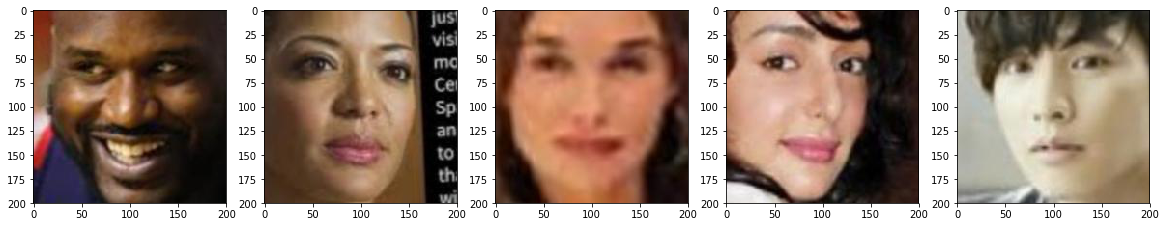

In [3]:
show_imgs('data/model_input/trainA')

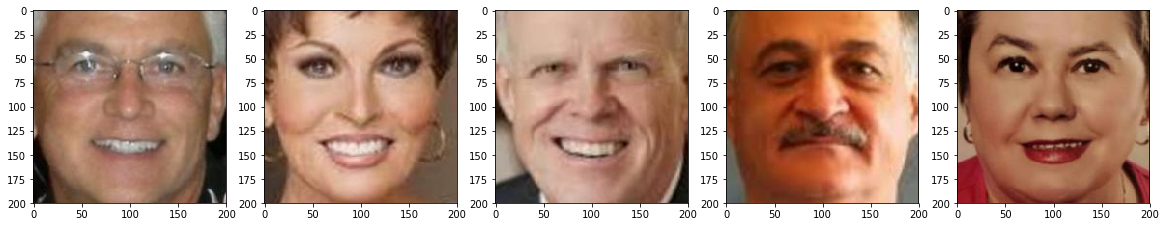

In [4]:
show_imgs('data/model_input/trainB')

# Modules

In [5]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
import numpy as np
from collections import namedtuple
import tensorflow as tf
import tensorflow.contrib.slim as slim
import math
import numpy as np
import pprint
import scipy.misc
import copy

In [6]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [7]:
def instance_norm(input, name="instance_norm"):
    with tf.variable_scope(name):
        depth = input.get_shape()[3]           # Number of channels.

        # Average 1, standard deviation 0.02 nomal distribution, ie number of channels.
        scale = tf.get_variable("scale", [depth], initializer=tf.random_normal_initializer(1.0, 0.02, dtype=tf.float32))

        # Create variable for the number of channels.
        offset = tf.get_variable("offset", [depth], initializer=tf.constant_initializer(0.0))

        mean, variance = tf.nn.moments(input, axes=[1,2], keep_dims=True)       # Find the mean and variance for the width and height.
        epsilon = 1e-5
        inv = tf.rsqrt(variance + epsilon)
        normalized = (input-mean)*inv
        return scale*normalized + offset

In [8]:
def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME', name="conv2d"):
    with tf.variable_scope(name):       # 앞에 conv2d가 붙음.
        # output_dim == Number of filters. ks == kernel size (4 x 4) s == stride, no active function.
        # Image size 0.5 times
        return slim.conv2d(input_, output_dim, ks, s, padding=padding, activation_fn=None,
                            weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                            biases_initializer=None)

In [9]:
def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name):
       # Image size is doubled in both horizontal and vertical directions.
        return slim.conv2d_transpose(input_, output_dim, ks, s, padding='SAME', activation_fn=None,
                                    weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                                    biases_initializer=None)

In [10]:
# Pooling images
class ImagePool(object):
    def __init__(self, maxsize=50):
        self.maxsize = maxsize
        self.num_img = 0
        self.images = []

    def __call__(self, image):
        if self.maxsize <= 0:
            return image
        if self.num_img < self.maxsize:
            self.images.append(image)
            self.num_img += 1
            return image
        if np.random.rand() > 0.5:
            idx = int(np.random.rand()*self.maxsize)
            tmp1 = copy.copy(self.images[idx])[0]
            self.images[idx][0] = image[0]
            idx = int(np.random.rand()*self.maxsize)
            tmp2 = copy.copy(self.images[idx])[1]
            self.images[idx][1] = image[1]
            return [tmp1, tmp2]
        else:
            return image

In [11]:
def sce_criterion(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

In [12]:
def mae_criterion(in_, target):
    return tf.reduce_mean((in_-target)**2)

In [13]:
def abs_criterion(in_, target):
    return tf.reduce_mean(tf.abs(in_ - target))

In [14]:
def discriminator(image, options, reuse=False, name="discriminator"):

    with tf.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False

        h0 = lrelu(conv2d(image, options.df_dim, name='d_h0_conv'))
        # h0 is (128 x 128 x self.df_dim)
        h1 = lrelu(instance_norm(conv2d(h0, options.df_dim*2, name='d_h1_conv'), 'd_bn1'))
        # h1 is (64 x 64 x self.df_dim*2)
        h2 = lrelu(instance_norm(conv2d(h1, options.df_dim*4, name='d_h2_conv'), 'd_bn2'))
        # h2 is (32x 32 x self.df_dim*4)
        h3 = lrelu(instance_norm(conv2d(h2, options.df_dim*8, s=1, name='d_h3_conv'), 'd_bn3'))
        # h3 is (32 x 32 x self.df_dim*8)
        h4 = conv2d(h3, 1, s=1, name='d_h3_pred')
        # h4 is (32 x 32 x 1)
        return h4

In [15]:
def generator_resnet(image, options, reuse=False, name="generator"):

    with tf.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False

        def residule_block(x, dim, ks=3, s=1, name='res'):
            p = int((ks - 1) / 2)
            y = tf.pad(x, [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")      # padding is only one side up or down. p is the padding value.

            # instance_norm은 nomalization.
            y = instance_norm(conv2d(y, dim, ks, s, padding='VALID', name=name+'_c1'), name+'_bn1')
            y = tf.pad(tf.nn.relu(y), [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")
            y = instance_norm(conv2d(y, dim, ks, s, padding='VALID', name=name+'_c2'), name+'_bn2')
            return y + x            # Shouldn't you be # 1/2 ??? Doesn't matter if you normalize afterwards ...

        # Justin Johnson's model from https://github.com/jcjohnson/fast-neural-style/
        # The network with 9 blocks consists of: c7s1-32, d64, d128, R128, R128, R128,
        # R128, R128, R128, R128, R128, R128, u64, u32, c7s1-3
        c0 = tf.pad(image, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")     # 3 padding up and down horizontally and vertically.
        c1 = tf.nn.relu(instance_norm(conv2d(c0, options.gf_dim, 7, 1, padding='VALID', name='g_e1_c'), 'g_e1_bn'))    # Padding is already valid.
        c2 = tf.nn.relu(instance_norm(conv2d(c1, options.gf_dim*2, 3, 2, name='g_e2_c'), 'g_e2_bn'))
        c3 = tf.nn.relu(instance_norm(conv2d(c2, options.gf_dim*4, 3, 2, name='g_e3_c'), 'g_e3_bn'))        # 64 *64

        # define G network with 9 resnet blocks
        # 18 floors total cnn.
        r1 = residule_block(c3, options.gf_dim*4, name='g_r1')
        r2 = residule_block(r1, options.gf_dim*4, name='g_r2')
        r3 = residule_block(r2, options.gf_dim*4, name='g_r3')
        r4 = residule_block(r3, options.gf_dim*4, name='g_r4')
        r5 = residule_block(r4, options.gf_dim*4, name='g_r5')
        r6 = residule_block(r5, options.gf_dim*4, name='g_r6')
        r7 = residule_block(r6, options.gf_dim*4, name='g_r7')
        r8 = residule_block(r7, options.gf_dim*4, name='g_r8')
        r9 = residule_block(r8, options.gf_dim*4, name='g_r9')

        d1 = deconv2d(r9, options.gf_dim*2, 3, 2, name='g_d1_dc')
        d1 = tf.nn.relu(instance_norm(d1, 'g_d1_bn'))
        d2 = deconv2d(d1, options.gf_dim, 3, 2, name='g_d2_dc')
        d2 = tf.nn.relu(instance_norm(d2, 'g_d2_bn'))
        d2 = tf.pad(d2, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")

        # I have padded above and use 7 by 7 filter.
        pred = tf.nn.tanh(conv2d(d2, options.output_c_dim, 7, 1, padding='VALID', name='g_pred_c'))



        return pred

# Utils

In [16]:
import cv2
import scipy.misc

def imreadf(path, is_grayscale = False):
    if (is_grayscale):
        return cv2.imread(path).astype(np.float)
    else:
        return cv2.imread(path).astype(np.float)

def load_test_data(image_path, fine_size=256):
    img = imreadf(image_path)
    img = cv2.resize(img, (fine_size, fine_size))
    img = img/127.5 - 1        
    return img

def load_train_data(image_path, load_size=286, fine_size=256, is_testing=False):
    img_A = imreadf(image_path[0])
    img_B = imreadf(image_path[1])

    if not is_testing:  
        img_A = cv2.resize(img_A, (load_size, load_size))
        img_B = cv2.resize(img_B, (load_size, load_size))
        h1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size))) 
        w1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
        img_A = img_A[h1:h1+fine_size, w1:w1+fine_size]        
        img_B = img_B[h1:h1+fine_size, w1:w1+fine_size]

        if np.random.random() > 0.5:               
            img_A = np.fliplr(img_A)
            img_B = np.fliplr(img_B)

    else:   # 테스트 중!
        img_A = cv2.resize(img_A, (fine_size, fine_size))
        img_B = cv2.resize(img_B, (fine_size, fine_size))

    img_A = img_A/127.5 - 1.
    img_B = img_B/127.5 - 1.

    img_AB = np.concatenate((img_A, img_B), axis=2)
    # img_AB shape: (fine_size, fine_size, input_c_dim + output_c_dim)
    return img_AB

def get_image(image_path, image_size, is_crop=True, resize_w=64, is_grayscale = False):
    return transform(imreadf(image_path, is_grayscale), image_size, is_crop, resize_w)

def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def merge_images(images, size):
    return inverse_transform(images)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image

    return img

def imsave(images, size, path):
    print('saving result to ', path)
    img=merge(images, size)
    print("log ", img.shape)
    plt.imshow(img)
    plt.savefig(path)
    return "Done"


def center_crop(x, crop_h, crop_w,
                resize_h=64, resize_w=64):
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]
    j = int(round((h - crop_h)/2.))
    i = int(round((w - crop_w)/2.))
    return cv2.resize(x[j:j+crop_h, i:i+crop_w], (resize_h, resize_w))

def transform(image, npx=64, is_crop=True, resize_w=64):
    # npx : # of pixels width/height of image
    if is_crop:
        cropped_image = center_crop(image, npx, resize_w=resize_w)
    else:
        cropped_image = image
    return np.array(cropped_image)/127.5 - 1.

def inverse_transform(images):
    return (images+1.)/2.

In [17]:
import cv2
i=cv2.imread('data/model_input/trainA/20_0_0_20170104230025073.jpg.chip.jpg').astype(np.float)
i.shape

(200, 200, 3)

In [18]:
v=cv2.resize(i,(256,256))

In [19]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

def disp(path):
    from IPython.display import Image
    display(Image(filename=path) )

In [20]:
from PIL import Image
def disp_gen(path):
    data=cv2.imread(path)
    img=Image.fromarray(data)
    display(img)

# Model

In [21]:
class cyclegan():
    def __init__(self, sess, checkpoint_dir, test_dir, dataset_dir, which_direction, batch_size,fine_size):
        self.sess = sess
        self.batch_size = batch_size
        self.image_size = fine_size       
        self.input_c_dim = 3        
        self.output_c_dim = 3       
        self.L1_lambda = 10.0
        self.fine_size = fine_size
        self.ngf = 64         # G first conv layer filter number
        self.ndf = 64         # D first conv layer filter count
        self.output_nc = 3
        self.max_size = 50
        self.beta1 = 0.5        # adam second option
        self.epoch = 1       
        self.epoch_step = 100   # Steps to reduce # lr
        self.train_size = 1e8   # Number of images at training ??
        self.lr_init = 0.0002        # The first lr
        self.load_size = 286
        self.save_freq = 500    # Storage frequency
        self.continue_train = True         # Always train continuously.

        # Path collection
        self.checkpoint_dir = checkpoint_dir        
        self.dataset_dir = dataset_dir              
        self.test_dir = test_dir                    # The path to save the test image.

        # G and D
        self.discriminator = discriminator
        self.generator = generator_resnet  # generator using resnet

        # loss_fn
        self.original_GAN_loss = mae_criterion

        self.which_direction = which_direction

        OPTIONS = namedtuple('OPTIONS', 'batch_size image_size \
                                      gf_dim df_dim output_c_dim')
        self.options = OPTIONS._make((self.batch_size, self.fine_size,
                                      self.ngf, self.ndf, self.output_nc,))       #ngf is the number of the first conv layer filter of the generator function
                                      #self.phase == 'train'))

        self._build_model()         # Create model
        #writer = tf.train.SummaryWriter("/tmp/test_logs", sess.graph)
        self.saver = tf.train.Saver()
        self.pool = ImagePool(self.max_size)

    def _build_model(self):
        self.real_data = tf.placeholder(tf.float32,
                                        [None, self.image_size, self.image_size,
                                         self.input_c_dim + self.output_c_dim],    # input image channel and output image channel number # probably both 3. RGB.
                                        name='real_A_and_B_images')

        self.real_A = self.real_data[:, :, :, :self.input_c_dim]            # The first part of self.real_data, ie, real A
        self.real_B = self.real_data[:, :, :, self.input_c_dim:self.input_c_dim + self.output_c_dim] # real B
        self.fake_B = self.generator(self.real_A, self.options, False, name="generatorA2B")     # Replace A with a fake B.
        self.fake_A_ = self.generator(self.fake_B, self.options, False, name="generatorB2A")    # Replace fake B with fake A
        # Use predefined reuse.
        self.fake_A = self.generator(self.real_B, self.options, True, name="generatorB2A")      # Replace real B with fake A
        self.fake_B_ = self.generator(self.fake_A, self.options, True, name="generatorA2B")     # Replace fake A with fake B
        self.DB_fake = self.discriminator(self.fake_B, self.options, reuse=False, name="discriminatorB")       # 32 BY 32 comes out ..
        self.DA_fake = self.discriminator(self.fake_A, self.options, reuse=False, name="discriminatorA")

        "" "The final loss necessary to learn G & F"
        self.g_loss = self.original_GAN_loss(self.DA_fake, tf.ones_like(self.DA_fake)) \
            + self.original_GAN_loss(self.DB_fake, tf.ones_like(self.DB_fake)) \
            + self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) \
            + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)


        self.fake_A_sample = tf.placeholder(tf.float32,
                                            [None, self.image_size, self.image_size,
                                             self.input_c_dim], name='fake_A_sample')
        self.fake_B_sample = tf.placeholder(tf.float32,
                                            [None, self.image_size, self.image_size,
                                             self.output_c_dim], name='fake_B_sample')

        # Put real B to get 32 by 32.
        self.DB_real = self.discriminator(self.real_B, self.options, reuse=True, name="discriminatorB")
        # Put real A to get 32 by 32.
        self.DA_real = self.discriminator(self.real_A, self.options, reuse=True, name="discriminatorA")
        ## Put a pseudo B to get 32 ​​by 32.
        self.DB_fake_sample = self.discriminator(self.fake_B_sample, self.options, reuse=True, name="discriminatorB")
        # Put a fake A to get 32 ​​by 32.
        self.DA_fake_sample = self.discriminator(self.fake_A_sample, self.options, reuse=True, name="discriminatorA")

        """ D_loss to distinguish real B from fake B """
        self.db_loss_real = self.original_GAN_loss(self.DB_real, tf.ones_like(self.DB_real))
        self.db_loss_fake = self.original_GAN_loss(self.DB_fake_sample, tf.zeros_like(self.DB_fake_sample))
        self.db_loss = (self.db_loss_real + self.db_loss_fake) / 2

        "" "D_loss distinguishes between real A and fake A" ""
        self.da_loss_real = self.original_GAN_loss(self.DA_real, tf.ones_like(self.DA_real))
        self.da_loss_fake = self.original_GAN_loss(self.DA_fake_sample, tf.zeros_like(self.DA_fake_sample))
        self.da_loss = (self.da_loss_real + self.da_loss_fake) / 2

        "" " Final loss for learning D "" "
        self.d_loss = self.da_loss + self.db_loss

        """============================================================================================"""

        """ Made for testing """
        self.test_A = tf.placeholder(tf.float32,
                                     [None, self.image_size, self.image_size,
                                      self.input_c_dim], name='test_A')
        self.test_B = tf.placeholder(tf.float32,
                                     [None, self.image_size, self.image_size,
                                      self.output_c_dim], name='test_B')
        self.testB = self.generator(self.test_A, self.options, True, name="generatorA2B")
        self.testA = self.generator(self.test_B, self.options, True, name="generatorB2A")


        """ We divide the variables when learning D and the variables when learning G. """
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]
#         for var in t_vars: print(var.name)

    def train(self):
        """Train cyclegan"""
        self.lr_var = tf.placeholder(tf.float32, None, name='learning_rate')
        self.d_optim = tf.train.AdamOptimizer(self.lr_var, beta1=self.beta1) \
            .minimize(self.d_loss, var_list=self.d_vars)
        self.g_optim = tf.train.AdamOptimizer(self.lr_var, beta1=self.beta1) \
            .minimize(self.g_loss, var_list=self.g_vars)

        """
        #########################################################
        self.hyunbo_optim = tf.train.AdamOptimizer(self.lr_var, beta1=self.beta1) \
            .minimize(self.g_loss_by_hyunbo, var_list=self.g_vars)
        #########################################################
        """

        init_op = tf.global_variables_initializer()    # Initialize all variables.
        self.sess.run(init_op)

        counter = 1
        start_time = time.time()

        if self.continue_train:
            suc_or_fal, num_of_train = self.load()         
            if suc_or_fal:
                print(" check point Import succeeded")
                counter = int(num_of_train.split('-')[1])                    # To save the next one ..
            else:
                print(" Failed to fetch check point")

        for epoch in range(self.epoch):
            dataA = glob('{}/*.*'.format(self.dataset_dir + '/trainA'))
            dataB = glob('{}/*.*'.format(self.dataset_dir + '/trainB'))
#             print("num of dataA : ", dataA.__len__())
#             print("num of dataB : ", dataB.__len__())
            np.random.shuffle(dataA)
            np.random.shuffle(dataB)
            batch_idxs = min(min(len(dataA), len(dataB)), self.train_size) // self.batch_size
            print("epoch starting for bs", self.batch_size)
            print("Number of mini batches :: ", batch_idxs)
            start_time = time.time()
            lr = self.lr_init if epoch < self.epoch_step else self.lr_init*(self.epoch-epoch)/(self.epoch-self.epoch_step)    

            for idx in range(0, batch_idxs):
                batch_files = list(zip(dataA[idx * self.batch_size:(idx + 1) * self.batch_size],
                                       dataB[idx * self.batch_size:(idx + 1) * self.batch_size]))
                # Change image size.
                batch_images = [load_train_data(batch_file, self.load_size, self.fine_size) for batch_file in batch_files] 
                batch_images = np.array(batch_images).astype(np.float32)
#                 print("batch_images", batch_images.shape)
                print(".", end="")
    
                # Update G network and record fake outputs
                fake_A, fake_B, _ = self.sess.run(
                    [self.fake_A, self.fake_B, self.g_optim],
                    feed_dict={self.real_data: batch_images, self.lr_var: lr})

                #self.writer.add_summary(summary_str, counter)
                #[fake_A, fake_B] = self.pool([fake_A, fake_B])

                # Update D network
                self.sess.run( [self.d_optim],
                               feed_dict={self.real_data: batch_images,
                                    self.fake_A_sample: fake_A,
                                    self.fake_B_sample: fake_B,
                                    self.lr_var: lr})
                #self.writer.add_summary(summary_str, counter)

                counter += 1

                # Save.
                if np.mod(counter, self.save_freq) == 2:
                    self.save(counter)
                    print("\n ckpt saved ", counter)
            print(("\n Epoch: [%2d] [%4d/%4d] time: %4.4f" % (epoch, idx, batch_idxs, time.time() - start_time)))

    def save(self, step):

        step_str = str(step)

        self.saver.save(self.sess,
                        self.checkpoint_dir + "/" + step_str,
                        global_step=step)


    def load(self):
        print(" [*] Reading checkpoint...")

        #model_dir = "%s_%s" % (self.dataset_dir, self.image_size)
        #checkpoint_dir = os.path.join(checkpoint_dir, model_dir)

        ckpt = tf.train.get_checkpoint_state(self.checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(self.checkpoint_dir, ckpt_name))
            print(" Checkpoint name !! :", ckpt_name)
            index = ckpt_name.find("-")
            num_of_train = ckpt_name[index + 1:]
            print(" Number of invoked ckpt:", num_of_train)
            time.sleep(10)
            return True, ckpt_name
        else:
            print("check point Is not in the path.")
            return False, 1          

    def test(self):
        """Test cyclegan"""
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        if self.which_direction == 'AtoB':
            sample_files = glob('{}/*.*'.format(self.dataset_dir + '/testA'))
            print("dataset Import succeeded.")
        elif self.which_direction == 'BtoA':
            sample_files = glob('{}/*.*'.format(self.dataset_dir + '/testB'))
            print("dataset Import succeeded.")
        else:
            raise Exception('AtoB BtoA Please choose one of them.')

        if self.load():
            print(" check point Import succeeded")
        else:
            print(" check point Import failed")

        if self.which_direction == 'AtoB':
            out_var, in_var = (self.testB, self.test_A)
        else:
            out_var, in_var = (self.testA, self.test_B)

        print (len(sample_files))
        for sample_file in sample_files:
            print('Processing image: ' + sample_file)
            sample_image = [load_test_data(sample_file, self.fine_size)]
            sample_image = np.array(sample_image).astype(np.float32)
            image_path = os.path.join(self.test_dir,
                                      '{0}_{1}'.format(self.which_direction, os.path.basename(sample_file)))
            fake_img = self.sess.run(out_var, feed_dict={in_var: sample_image})
            print("start saving")
            save_images(fake_img, [1, 1], image_path)


# Training

In [22]:
def run(phase,checkpoint_dir,which_direction="B2A",batch_size=32,fine_size=256,epoch=5):
    checkpoint_dir=checkpoint_dir
    test_dir = './test'                      
    dataset_dir = './data/model_input/'               
    phase = phase  # or test
    which_direction = which_direction  # or BtoA
    batch_size=batch_size
    fine_size=fine_size
    epoch=epoch

    def createDir(direc):
        if not os.path.exists(direc):
            os.makedirs(direc)
            
    createDir(test_dir)
    createDir(dataset_dir)
    
    tfconfig = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)        # Using GPU
    tfconfig.gpu_options.allow_growth = True
    
    tf.reset_default_graph() #Reset the old tf graphs on gpu
    
    with tf.Session(config=tfconfig) as sess:
        model = cyclegan(sess, checkpoint_dir = checkpoint_dir, test_dir = test_dir,\
                         dataset_dir= dataset_dir, which_direction= which_direction, batch_size=batch_size,fine_size=fine_size)
        model.epoch=epoch
        if phase == 'train':
            print("Training ")
            model.train()
        elif phase == "test":
            print(" Testing")
            model.test()
        else:
            print(" train??? test????")

In [23]:
run("train",'./checkpoint/trail_1' ,batch_size=32,fine_size=64,epoch=10)

KeyboardInterrupt: 

 Testing
dataset Import succeeded.
 [*] Reading checkpoint...
 Checkpoint name !! : 502-502
 Number of invoked ckpt: 502
 check point Import succeeded
1
Processing image: ./data/model_input//testA/KakaoTalk_20181212_013947907.jpg
start saving
saving result to  ./test/AtoB_KakaoTalk_20181212_013947907.jpg
log  (256, 256, 3)


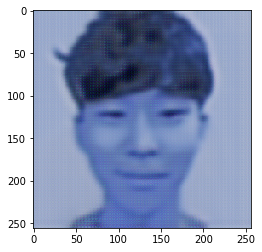

In [171]:
run("test",'./checkpoint/trail_1',which_direction="AtoB")

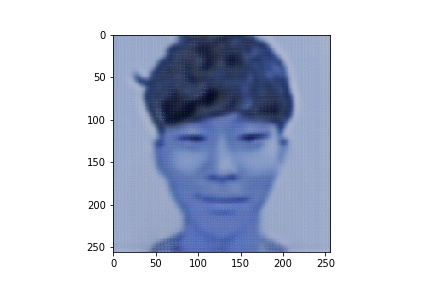

In [172]:
disp('./test/AtoB_KakaoTalk_20181212_013947907.jpg')

In [144]:
!ls data/model_input/testA

KakaoTalk_20181212_013947907.jpg


In [174]:
run("train",'./checkpoint/trail_1' ,batch_size=16,fine_size=96,epoch=15)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 502-502
 Number of invoked ckpt: 502
 check point Import succeeded
epoch starting for bs 16
Epoch: [ 0] [ 142/ 143] time: 210.4126
epoch starting for bs 16
Epoch: [ 1] [ 142/ 143] time: 198.4986
epoch starting for bs 16
Epoch: [ 2] [ 142/ 143] time: 198.7487
epoch starting for bs 16
ckpt saved
Epoch: [ 3] [ 142/ 143] time: 200.7320
epoch starting for bs 16
Epoch: [ 4] [ 142/ 143] time: 198.6803
epoch starting for bs 16
Epoch: [ 5] [ 142/ 143] time: 198.5148
epoch starting for bs 16
ckpt saved
Epoch: [ 6] [ 142/ 143] time: 200.1651
epoch starting for bs 16
Epoch: [ 7] [ 142/ 143] time: 198.7298
epoch starting for bs 16
Epoch: [ 8] [ 142/ 143] time: 198.8582
epoch starting for bs 16
Epoch: [ 9] [ 142/ 143] time: 198.7287
epoch starting for bs 16
ckpt saved
Epoch: [10] [ 142/ 143] time: 200.2777
epoch starting for bs 16
Epoch: [11] [ 142/ 143] time: 198.6377
epoch starting for bs 16
Epoch: [12] [ 142/ 143] time: 198.7590
epoch sta

In [215]:
run("test",'./checkpoint/trail_1',which_direction="BtoA")

 Testing
dataset Import succeeded.
 [*] Reading checkpoint...
 Checkpoint name !! : 4002-4002
 Number of invoked ckpt: 4002
 check point Import succeeded
1
Processing image: ./data/model_input//testB/59_0_1_20170111171747518.jpg.chip.jpg
start saving
saving result to  ./test/BtoA_59_0_1_20170111171747518.jpg.chip.jpg
log  (256, 256, 3)


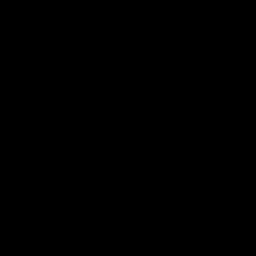

In [216]:
disp('./test/BtoA_59_0_1_20170111171747518.jpg.chip.jpg')

 Testing
dataset Import succeeded.
 [*] Reading checkpoint...
 Checkpoint name !! : 2502-2502
 Number of invoked ckpt: 2502
 check point Import succeeded
1
Processing image: ./data/model_input//testA/KakaoTalk_20181212_013947907.jpg
start saving
saving result to  ./test/AtoB_KakaoTalk_20181212_013947907.jpg
log  (256, 256, 3)


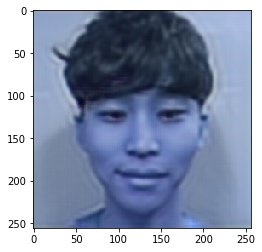

In [177]:
run("test",'./checkpoint/trail_1',which_direction="AtoB")

In [178]:
run("train",'./checkpoint/trail_1' ,batch_size=16,fine_size=96,epoch=5)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 2502-2502
 Number of invoked ckpt: 2502
 check point Import succeeded
epoch starting for bs 16
Epoch: [ 0] [ 142/ 143] time: 209.3600
epoch starting for bs 16
Epoch: [ 1] [ 142/ 143] time: 198.6552
epoch starting for bs 16
Epoch: [ 2] [ 142/ 143] time: 198.7019
epoch starting for bs 16
ckpt saved  3002
Epoch: [ 3] [ 142/ 143] time: 200.6860
epoch starting for bs 16
Epoch: [ 4] [ 142/ 143] time: 198.4857


 Testing
dataset Import succeeded.
 [*] Reading checkpoint...
 Checkpoint name !! : 4002-4002
 Number of invoked ckpt: 4002
 check point Import succeeded
1
Processing image: ./data/model_input//testA/KakaoTalk_20181212_013947907.jpg
start saving
saving result to  ./test/AtoB_KakaoTalk_20181212_013947907.jpg
log  (256, 256, 3)


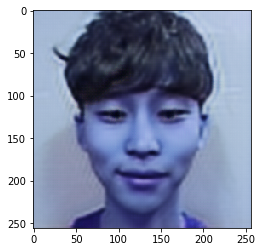

In [226]:
run("test",'./checkpoint/trail_1',which_direction="AtoB")

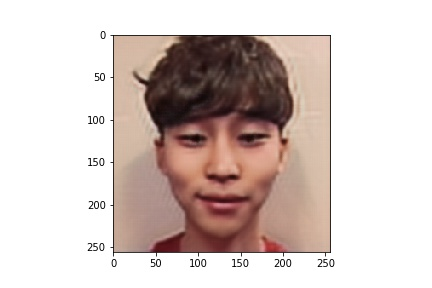

In [227]:
disp_gen('./test/AtoB_KakaoTalk_20181212_013947907.jpg')

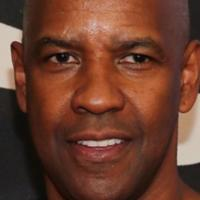

In [200]:
disp('./data/model_input//testB/59_0_1_20170111171747518.jpg.chip.jpg')

In [183]:
run("train",'./checkpoint/trail_1' ,batch_size=9,fine_size=128,epoch=5)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 3002-3002
 Number of invoked ckpt: 3002
 check point Import succeeded
epoch starting for bs 9
Epoch: [ 0] [ 254/ 255] time: 385.1362
epoch starting for bs 9
ckpt saved  3502
Epoch: [ 1] [ 254/ 255] time: 377.9984
epoch starting for bs 9
Epoch: [ 2] [ 254/ 255] time: 376.2918
epoch starting for bs 9
ckpt saved  4002
Epoch: [ 3] [ 254/ 255] time: 377.6072
epoch starting for bs 9
Epoch: [ 4] [ 254/ 255] time: 376.0673


In [ ]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=5)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 4002-4002
 Number of invoked ckpt: 4002
 check point Import succeeded
epoch starting for bs 2
ckpt saved  4502
ckpt saved  5002
Epoch: [ 0] [1148/1149] time: 1526.3097
epoch starting for bs 2
ckpt saved  5502
ckpt saved  6002


In [23]:
run("train",'./checkpoint/trail_1' ,batch_size=9,fine_size=128,epoch=10)

W0803 18:08:36.842416 140411707574016 deprecation.py:506] From <ipython-input-7-b7e5f33d89e9>:6: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 18:08:41.475132 140411707574016 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training 


W0803 18:08:58.878289 140411707574016 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


 [*] Reading checkpoint...
 Checkpoint name !! : 6002-6002
 Number of invoked ckpt: 6002
 check point Import succeeded
epoch starting for bs 9
Epoch: [ 0] [ 254/ 255] time: 423.2487
epoch starting for bs 9
ckpt saved  6502
Epoch: [ 1] [ 254/ 255] time: 389.3316
epoch starting for bs 9
Epoch: [ 2] [ 254/ 255] time: 380.3675
epoch starting for bs 9
ckpt saved  7002
Epoch: [ 3] [ 254/ 255] time: 380.6528
epoch starting for bs 9
Epoch: [ 4] [ 254/ 255] time: 376.0879
epoch starting for bs 9
ckpt saved  7502
Epoch: [ 5] [ 254/ 255] time: 376.5776
epoch starting for bs 9
Epoch: [ 6] [ 254/ 255] time: 373.9140
epoch starting for bs 9
ckpt saved  8002
Epoch: [ 7] [ 254/ 255] time: 373.5779
epoch starting for bs 9
Epoch: [ 8] [ 254/ 255] time: 371.5659
epoch starting for bs 9
ckpt saved  8502
Epoch: [ 9] [ 254/ 255] time: 372.8027


In [24]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=5)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 8502-8502
 Number of invoked ckpt: 8502
 check point Import succeeded
epoch starting for bs 2
ckpt saved  9002
ckpt saved  9502
Epoch: [ 0] [1148/1149] time: 1515.2285
epoch starting for bs 2
ckpt saved  10002
ckpt saved  10502
Epoch: [ 1] [1148/1149] time: 1502.6741
epoch starting for bs 2
ckpt saved  11002


W0803 20:22:23.369004 140411707574016 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


ckpt saved  11502
Epoch: [ 2] [1148/1149] time: 1502.3884
epoch starting for bs 2
ckpt saved  12002
ckpt saved  12502
ckpt saved  13002
Epoch: [ 3] [1148/1149] time: 1504.3786
epoch starting for bs 2
ckpt saved  13502
ckpt saved  14002
Epoch: [ 4] [1148/1149] time: 1503.1526


In [ ]:
run("train",'./checkpoint/trail_1' ,batch_size=9,fine_size=128,epoch=10)

W0805 06:40:05.683767 140143048509184 deprecation.py:506] From <ipython-input-7-b7e5f33d89e9>:6: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 06:40:09.964293 140143048509184 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training 


W0805 06:40:27.058739 140143048509184 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


 [*] Reading checkpoint...
 Checkpoint name !! : 14002-14002
 Number of invoked ckpt: 14002
 check point Import succeeded
epoch starting for bs 9
Epoch: [ 0] [ 254/ 255] time: 412.3136
epoch starting for bs 9
ckpt saved  14502
Epoch: [ 1] [ 254/ 255] time: 384.8230
epoch starting for bs 9
Epoch: [ 2] [ 254/ 255] time: 380.0113
epoch starting for bs 9


In [ ]:
run("train",'./checkpoint/trail_1' ,batch_size=9,fine_size=128,epoch=20)

W0805 08:59:56.314337 140392974653184 deprecation.py:506] From <ipython-input-7-b7e5f33d89e9>:6: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0805 09:00:00.684485 140392974653184 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training 


W0805 09:00:18.023362 140392974653184 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


 [*] Reading checkpoint...
 Checkpoint name !! : 16502-16502
 Number of invoked ckpt: 16502
 check point Import succeeded
epoch starting for bs 9
Epoch: [ 0] [ 254/ 255] time: 428.9577
epoch starting for bs 9
ckpt saved  17002
Epoch: [ 1] [ 254/ 255] time: 388.9338
epoch starting for bs 9
Epoch: [ 2] [ 254/ 255] time: 379.8856
epoch starting for bs 9
ckpt saved  17502
Epoch: [ 3] [ 254/ 255] time: 379.0461
epoch starting for bs 9
Epoch: [ 4] [ 254/ 255] time: 375.9535
epoch starting for bs 9
ckpt saved  18002
Epoch: [ 5] [ 254/ 255] time: 376.3728
epoch starting for bs 9


In [ ]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=10)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 18502-18502
 Number of invoked ckpt: 18502
 check point Import succeeded
epoch starting for bs 2
ckpt saved  19002
ckpt saved  19502
Epoch: [ 0] [1148/1149] time: 1542.8177
epoch starting for bs 2
ckpt saved  20002
ckpt saved  20502
Epoch: [ 1] [1148/1149] time: 1505.7665
epoch starting for bs 2
ckpt saved  21002


W0805 11:56:43.123786 140401035396864 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


ckpt saved  21502
Epoch: [ 2] [1148/1149] time: 1500.7845
epoch starting for bs 2
ckpt saved  22002
ckpt saved  22502
ckpt saved  23002
Epoch: [ 3] [1148/1149] time: 1498.1415
epoch starting for bs 2
ckpt saved  23502
ckpt saved  24002
Epoch: [ 4] [1148/1149] time: 1495.3570
epoch starting for bs 2
ckpt saved  24502
ckpt saved  25002
Epoch: [ 5] [1148/1149] time: 1493.3422
epoch starting for bs 2
ckpt saved  25502
ckpt saved  26002


W0813 04:17:11.246272 140573134845696 deprecation.py:506] From <ipython-input-7-b7e5f33d89e9>:6: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


 Testing


W0813 04:17:16.595156 140573134845696 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


dataset Import succeeded.
 [*] Reading checkpoint...
 Checkpoint name !! : 37002-37002
 Number of invoked ckpt: 37002
 check point Import succeeded
3
Processing image: ./data/model_input//testA/21_0_3_20170119150216454.jpg.chip.jpg
start saving
saving result to  ./test/AtoB_21_0_3_20170119150216454.jpg.chip.jpg
log  (256, 256, 3)
Processing image: ./data/model_input//testA/KakaoTalk_20181212_013947907.jpg
start saving
saving result to  ./test/AtoB_KakaoTalk_20181212_013947907.jpg
log  (256, 256, 3)
Processing image: ./data/model_input//testA/21_1_2_20170116171134381.jpg.chip.jpg
start saving
saving result to  ./test/AtoB_21_1_2_20170116171134381.jpg.chip.jpg
log  (256, 256, 3)


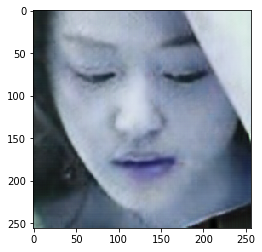

In [25]:
run("test",'./checkpoint/trail_1',which_direction="AtoB")

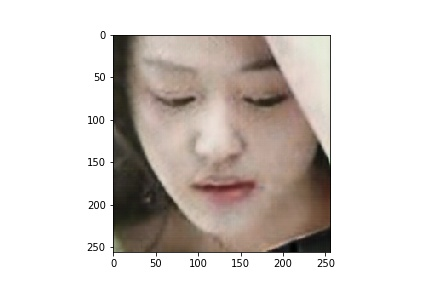

In [26]:
disp_gen('./test/AtoB_21_1_2_20170116171134381.jpg.chip.jpg')

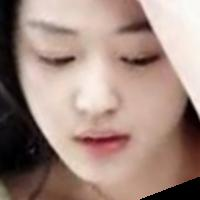

In [39]:
disp('./data/model_input//testA/21_1_2_20170116171134381.jpg.chip.jpg')

In [32]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=5)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 29502-29502
 Number of invoked ckpt: 29502
 check point Import succeeded
epoch starting for bs 2
ckpt saved  30002
ckpt saved  30502
Epoch: [ 0] [1148/1149] time: 1505.9309
epoch starting for bs 2
ckpt saved  31002
ckpt saved  31502
Epoch: [ 1] [1148/1149] time: 1492.2916
epoch starting for bs 2
ckpt saved  32002
ckpt saved  32502
Epoch: [ 2] [1148/1149] time: 1492.4420
epoch starting for bs 2
ckpt saved  33002
ckpt saved  33502
ckpt saved  34002
Epoch: [ 3] [1148/1149] time: 1493.5332
epoch starting for bs 2
ckpt saved  34502
ckpt saved  35002
Epoch: [ 4] [1148/1149] time: 1491.9858


In [40]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=2)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 35002-35002
 Number of invoked ckpt: 35002
 check point Import succeeded
epoch starting for bs 2
ckpt saved  35502
ckpt saved  36002
Epoch: [ 0] [1148/1149] time: 1507.5218
epoch starting for bs 2
ckpt saved  36502
ckpt saved  37002
Epoch: [ 1] [1148/1149] time: 1494.4305


In [ ]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=10)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 37002-37002
 Number of invoked ckpt: 37002
 check point Import succeeded
epoch starting for bs 2
Number of mini batches ::  1149
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

W0813 05:30:20.441862 140573134845696 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.



 ckpt saved  40002
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................
 Epoch: [ 2] [1148/1149] time: 1523.8819
epoch starting for bs 2
Number of mini batches ::  1149
.....................................................
 ckpt saved  40502
..........................................................................................................................................................................................................................................................................................................................................................................

In [31]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=10)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 48002-48002
 Number of invoked ckpt: 48002
 check point Import succeeded
epoch starting for bs 2
Number of mini batches ::  1149
..................................................................................................................................................................................................................................................................................................................................................................................................................................
 ckpt saved  48502
......................................................................................................................................................................................................................................................................................................................................................................................

 Testing
dataset Import succeeded.
 [*] Reading checkpoint...
 Checkpoint name !! : 59002-59002
 Number of invoked ckpt: 59002
 check point Import succeeded
3
Processing image: ./data/model_input//testA/21_0_3_20170119150216454.jpg.chip.jpg
start saving
saving result to  ./test/AtoB_21_0_3_20170119150216454.jpg.chip.jpg
log  (256, 256, 3)
Processing image: ./data/model_input//testA/KakaoTalk_20181212_013947907.jpg
start saving
saving result to  ./test/AtoB_KakaoTalk_20181212_013947907.jpg
log  (256, 256, 3)
Processing image: ./data/model_input//testA/21_1_2_20170116171134381.jpg.chip.jpg
start saving
saving result to  ./test/AtoB_21_1_2_20170116171134381.jpg.chip.jpg
log  (256, 256, 3)


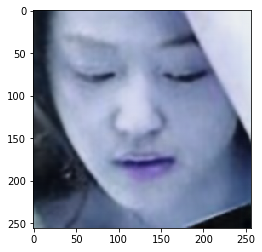

In [32]:
run("test",'./checkpoint/trail_1',which_direction="AtoB")

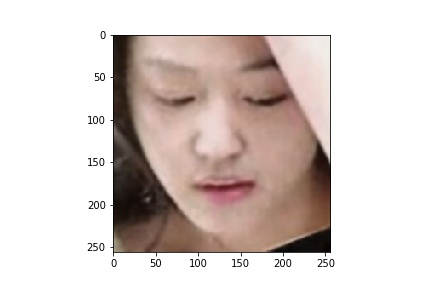

In [33]:
disp_gen('./test/AtoB_21_1_2_20170116171134381.jpg.chip.jpg')

In [ ]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=10)

Training 
 [*] Reading checkpoint...
 Checkpoint name !! : 59002-59002
 Number of invoked ckpt: 59002
 check point Import succeeded
epoch starting for bs 2
Number of mini batches ::  1149
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
 ckpt saved  59502
....................................................................................................................................................................................................................................................................................................

In [ ]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=10)

W0815 05:28:36.250791 139850863216384 deprecation.py:506] From <ipython-input-7-b7e5f33d89e9>:6: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0815 05:28:40.512878 139850863216384 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training 


W0815 05:28:57.728580 139850863216384 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


 [*] Reading checkpoint...
 Checkpoint name !! : 70002-70002
 Number of invoked ckpt: 70002
 check point Import succeeded
epoch starting for bs 2
Number of mini batches ::  1149
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
 ckpt saved  70502
..............................................................................................................................................................................................................................................................................................................

In [ ]:
run("train",'./checkpoint/trail_1' ,batch_size=2,fine_size=256,epoch=30)

In [32]:
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

In [33]:
model_summary()


---------
Variables: name (type shape) [size]
---------
Total size of variables: 0
Total bytes of variables: 0


In [30]:
    tf.reset_default_graph() #Reset the old tf graphs on gpu

